In [1]:
from obspy.core import Stream, read, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path
from mudpy import forward

In [2]:
path = '/Users/sydneydybing/StrainProject/2024/tohoku_strain_data/'

stas = pd.read_csv(path + 'stations.list', delimiter = '\s+')
chans = ['S1', 'S2', 'S3', 'S4']
stas

,Station_name,latitude,longitude,azimuth(S1),azimuth(S2),azimuth(S3),azimuth(S4)
0,KST1,33.5201,135.8363,310,40,85,175
1,HGM1,33.8675,135.7318,337,67,112,202
2,ICU1,33.9001,136.1379,141,231,276,6
3,ANO1,34.7870,136.4019,38,128,173,263
4,SSK1,33.3896,133.3229,355,85,130,220
5,UWA1,33.3859,132.4823,222,312,357,87
6,MUR1,33.2856,134.1563,147,237,282,12
7,MYM1,34.1123,136.1815,237,327,12,102


In [3]:
# Picks on seismic

u_picks = np.genfromtxt('/Users/sydneydybing/StrainProject/2024/tohoku_seismic_data/Seismic_DATA/u_for_picking/seismic_u_picks', dtype = str)
# print(u_picks)

# Get list of stations from the order in these files

u_pick_file_stainfo = u_picks[:,3]
u_pick_file_stas = []
for idx in range(len(u_pick_file_stainfo)):
    u_pick_file_sta = u_pick_file_stainfo[idx].split('.')[2]
    
    if u_pick_file_sta == 'AN':
        u_pick_file_sta = 'ANO1'
    elif u_pick_file_sta == 'MY':
        u_pick_file_sta = 'MYM1'
    elif u_pick_file_sta == 'IC':
        u_pick_file_sta = 'ICU1'
    elif u_pick_file_sta == 'HG':
        u_pick_file_sta = 'HGM1'
    elif u_pick_file_sta == 'KS':
        u_pick_file_sta = 'KST1'
    elif u_pick_file_sta == 'MU':
        u_pick_file_sta = 'MUR1'
    elif u_pick_file_sta == 'SS':
        u_pick_file_sta = 'SSK1'
    elif u_pick_file_sta == 'UW':
        u_pick_file_sta = 'UWA1'
    
    u_pick_file_stas.append(u_pick_file_sta)
u_pick_file_stas = np.array(u_pick_file_stas)

print(u_pick_file_stas)

['ANO1' 'MYM1' 'ICU1' 'HGM1' 'KST1' 'MUR1' 'SSK1' 'UWA1']


KST1


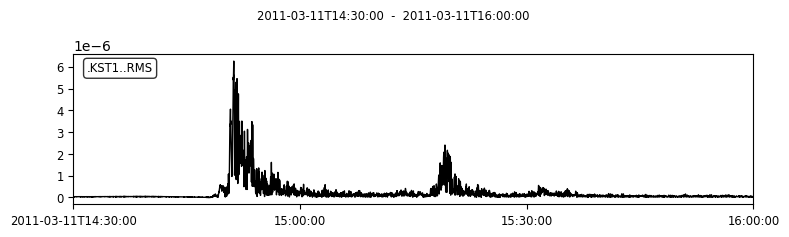

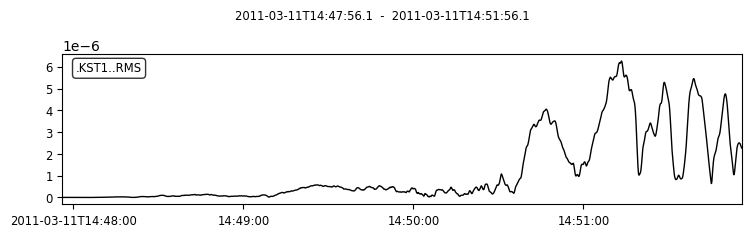

HGM1


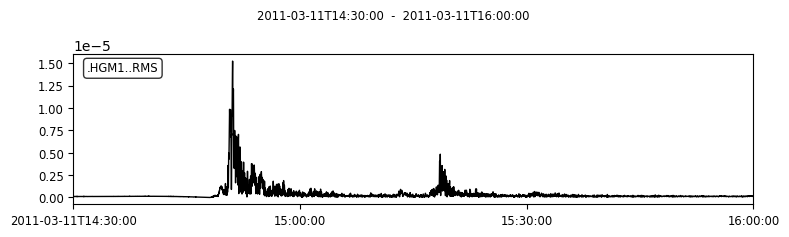

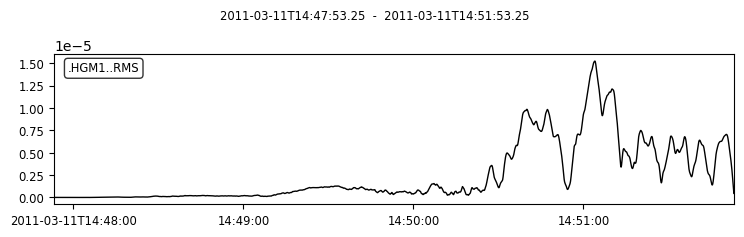

ICU1


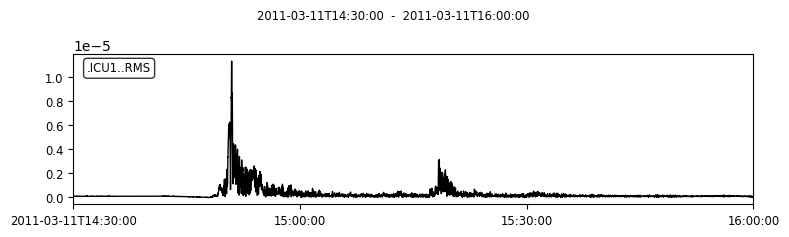

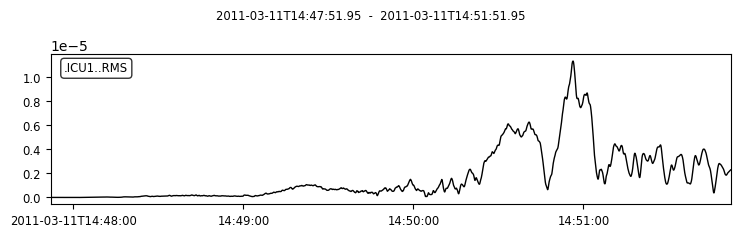

ANO1


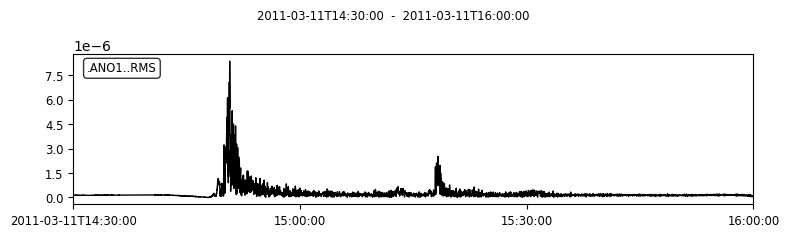

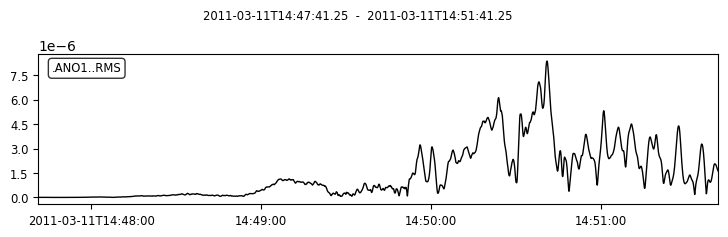

SSK1


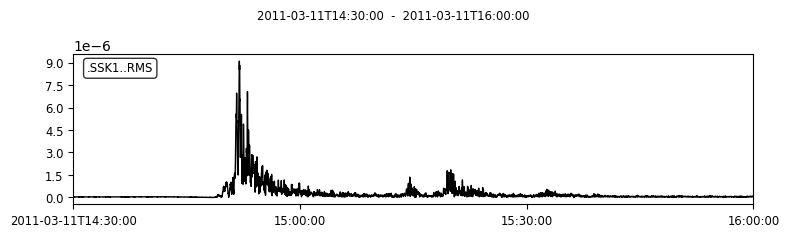

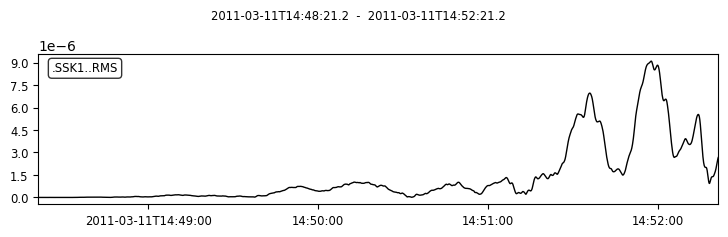

UWA1


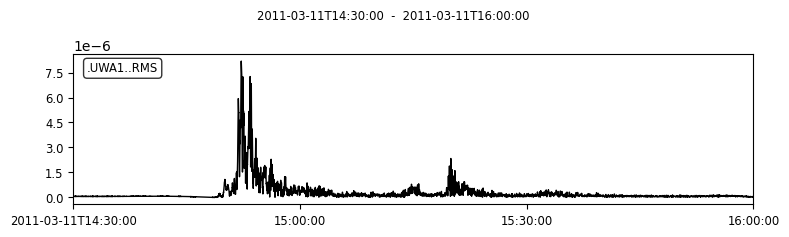

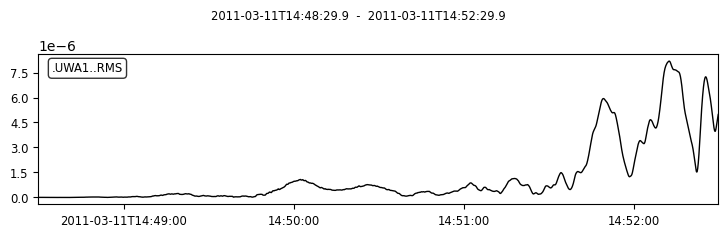

MUR1


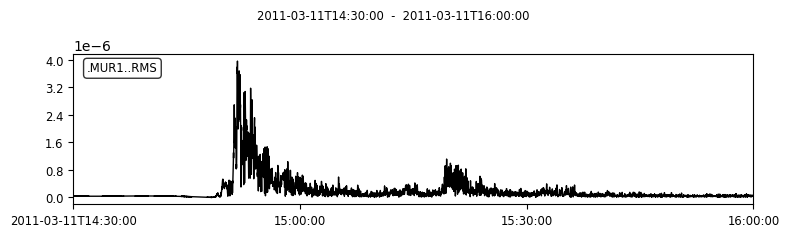

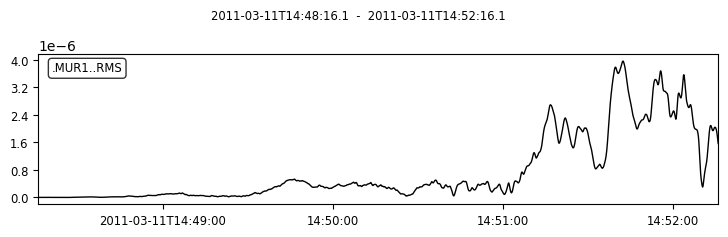

MYM1


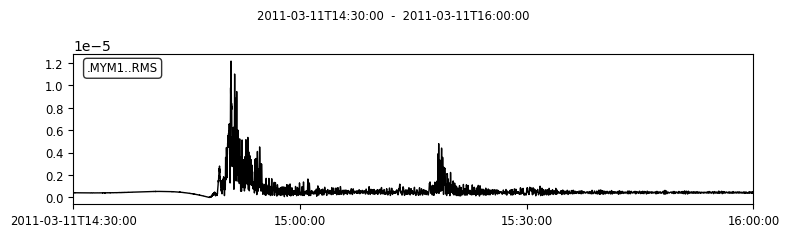

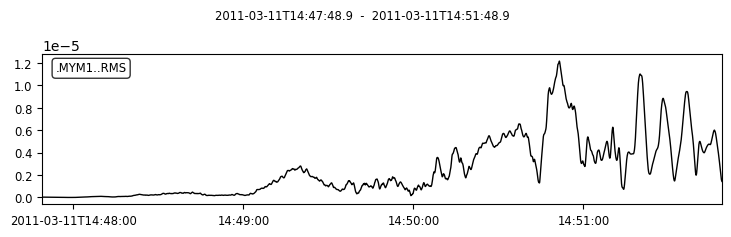

In [6]:
for idx in range(len(stas)):

    sta = stas['Station_name'][idx]
    print(sta)
    
    i_u = np.where(u_pick_file_stas == sta)[0]
    u_pick_date = u_picks[i_u,0][0]
    u_pick_time = u_picks[i_u,1][0]
    u_pick_datetime = UTCDateTime(str(u_pick_date) + 'T' + str(u_pick_time) + 'Z')
    u_starttime = u_pick_datetime - 10 # 10 seconds before pick time
    u_endtime = u_starttime + 240 # full trace will be 4 minutes long
    
    S1 = read(path + 'DATA/' + str(sta) + '.S1')
    S2 = read(path + 'DATA/' + str(sta) + '.S2')
    S3 = read(path + 'DATA/' + str(sta) + '.S3')
    
    starttime = UTCDateTime('2011-03-11T14:30:00.000000Z')
    endtime = UTCDateTime('2011-03-11T16:00:00.000000Z')

    S1.trim(starttime, endtime)
    S2.trim(starttime, endtime)
    S3.trim(starttime, endtime)

    # High-pass filter
    corner_period = 1000 # seconds
    corner_freq = 1/corner_period

    filterS1 = S1.copy()
    filterS2 = S2.copy()
    filterS3 = S3.copy()

    filterS1[0].data = forward.highpass(S1[0].data, fcorner = corner_freq, fsample = S1[0].stats.sampling_rate, order = 4)
    filterS2[0].data = forward.highpass(S2[0].data, fcorner = corner_freq, fsample = S2[0].stats.sampling_rate, order = 4)
    filterS3[0].data = forward.highpass(S3[0].data, fcorner = corner_freq, fsample = S3[0].stats.sampling_rate, order = 4)

    # Detrend
    # Figure out which sample has the UTCDateTime P-wave arrival
    utc_times = filterS1[0].times(type = 'utcdatetime')
    diffs = []
    for time in utc_times:
        diff = np.abs(time - u_pick_datetime)
        diffs.append(diff)
    l = np.where(np.array(diffs) == np.min(np.array(diffs)))[0]
    utcdt_arrival = utc_times[l][0]
    # l = np.where(utc_times == pick_datetime)[0]
    # print('Actual pick:')
    # print(u_pick_datetime)
    # print('Closest time in data:')
    # print(utcdt_arrival)
    data_p_arr_idx = np.where(utc_times == utcdt_arrival)[0][0]
    # print(data_p_arr_idx)
    
    filterS1[0].data = filterS1[0].data - np.mean(filterS1[0].data[data_p_arr_idx-2:data_p_arr_idx+2])
    filterS2[0].data = filterS2[0].data - np.mean(filterS2[0].data[data_p_arr_idx-2:data_p_arr_idx+2])
    filterS3[0].data = filterS3[0].data - np.mean(filterS3[0].data[data_p_arr_idx-2:data_p_arr_idx+2])
    
    RMS_strain = np.sqrt(((filterS1[0].data)**2 + (filterS2[0].data)**2 + (filterS3[0].data)**2)/3)         

    times = filterS1[0].times()

    RMS_st = filterS1.copy()
    RMS_st[0].stats.channel = 'RMS'
    RMS_st[0].data = RMS_strain

    RMS_st[0].plot()
    # print(RMS_st[0].stats)

    # Create folder for the event
    eq_sta_save_dir = path + '3comp_rms_newdetrend/'
    # print(eq_sta_save_dir)
    if os.path.isdir(eq_sta_save_dir):
        pass
    else:
        os.makedirs(eq_sta_save_dir)

    RMS_st.write(eq_sta_save_dir + sta + '.mseed', format = 'MSEED')

    RMS = read(path + '3comp_rms_newdetrend/' + str(sta) + '.mseed')
    # RMS.plot()
    
    stream_starttime = RMS[0].stats.starttime
    # print(stream_starttime)
    
    p_arrival_secs_u = u_pick_datetime - stream_starttime
    
    RMS_times = RMS[0].times()
    RMS_data = RMS[0].data
    
#     plt.title(sta)
#     plt.plot(RMS_times, RMS_data)
#     plt.axvline(p_arrival_secs_u, color = 'green', label = 'P pick')
    
#     # plt.xlim(1060,1150)
#     plt.ylim(0, max(RMS_data[1060*20:1150*20])*1.1)
#     plt.xlim(p_arrival_secs_u-10, p_arrival_secs_u+120)
#     plt.ylim(0, max(RMS_data[int((p_arrival_secs_u-10)*20):int((p_arrival_secs_u+120)*20)])*1.1)
#     plt.legend()
#     plt.show()
    
    RMS_trim = RMS.trim(starttime = u_starttime, endtime = u_endtime, pad = True, fill_value = 0)
    RMS_trim.plot()

    # Extracting just the RMS data, now trimmed properly, and saving it to a new miniSEED file.

    RMS_times_trim = RMS_trim[0].times()
    RMS_data_trim = RMS_trim[0].data
    RMS_trim[0].stats.channel = 'tBSR'

    # Create folder for the event
    eq_sta_save_dir = path + '3comp_trimmed_rms_newdetrend/'
#                 print(eq_sta_save_dir)
    if os.path.isdir(eq_sta_save_dir):
        pass
    else:
        os.makedirs(eq_sta_save_dir)

    RMS_trim.write(eq_sta_save_dir + sta + '.mseed', format = 'MSEED')

In [48]:
# Picks on strain

s1_picks = np.genfromtxt(path + 'picks_on_s1', dtype = str)
s2_picks = np.genfromtxt(path + 'picks_on_s2', dtype = str)
s3_picks = np.genfromtxt(path + 'picks_on_s3', dtype = str)
s4_picks = np.genfromtxt(path + 'picks_on_s4', dtype = str)
rms_picks = np.genfromtxt(path + 'picks_on_rms', dtype = str)

# Get list of stations from the order in these files

rms_pick_file_stainfo = rms_picks[:,3]
rms_pick_file_stas = []
for idx2 in range(len(rms_pick_file_stainfo)):
    rms_pick_file_sta = rms_pick_file_stainfo[idx2].split('.')[1]
    rms_pick_file_stas.append(rms_pick_file_sta)
rms_pick_file_stas = np.array(rms_pick_file_stas)

s1_pick_file_stainfo = s1_picks[:,3]
s1_pick_file_stas = []
for idx3 in range(len(s1_pick_file_stainfo)):
    s1_pick_file_sta = s1_pick_file_stainfo[idx3].split('.')[1]
    s1_pick_file_stas.append(s1_pick_file_sta)
s1_pick_file_stas = np.array(s1_pick_file_stas)

s2_pick_file_stainfo = s2_picks[:,3]
s2_pick_file_stas = []
for idx4 in range(len(s2_pick_file_stainfo)):
    s2_pick_file_sta = s2_pick_file_stainfo[idx4].split('.')[1]
    s2_pick_file_stas.append(s2_pick_file_sta)
s2_pick_file_stas = np.array(s2_pick_file_stas)

s3_pick_file_stainfo = s3_picks[:,3]
s3_pick_file_stas = []
for idx5 in range(len(s3_pick_file_stainfo)):
    s3_pick_file_sta = s3_pick_file_stainfo[idx5].split('.')[1]
    s3_pick_file_stas.append(s3_pick_file_sta)
s3_pick_file_stas = np.array(s3_pick_file_stas)

s4_pick_file_stainfo = s4_picks[:,3]
s4_pick_file_stas = []
for idx6 in range(len(s4_pick_file_stainfo)):
    s4_pick_file_sta = s4_pick_file_stainfo[idx6].split('.')[1]
    s4_pick_file_stas.append(s4_pick_file_sta)
s4_pick_file_stas = np.array(s4_pick_file_stas)

print(rms_pick_file_stas)
print(s1_pick_file_stas)
print(s2_pick_file_stas)
print(s3_pick_file_stas)
print(s4_pick_file_stas)

['ANO1' 'MYM1' 'ICU1' 'HGM1' 'KST1' 'MUR1' 'SSK1' 'UWA1']
['ANO1' 'MYM1' 'ICU1' 'HGM1' 'KST1' 'MUR1' 'SSK1' 'UWA1']
['ANO1' 'MYM1' 'ICU1' 'HGM1' 'KST1' 'MUR1' 'SSK1' 'UWA1']
['ANO1' 'MYM1' 'ICU1' 'HGM1' 'KST1' 'MUR1' 'SSK1' 'UWA1']
['ANO1' 'ICU1' 'MYM1' 'HGM1' 'KST1' 'MUR1' 'SSK1' 'UWA1']


KST1


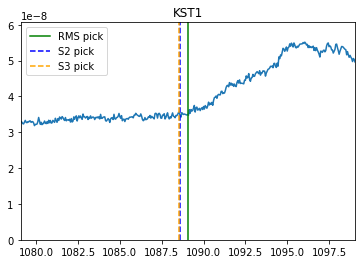

HGM1


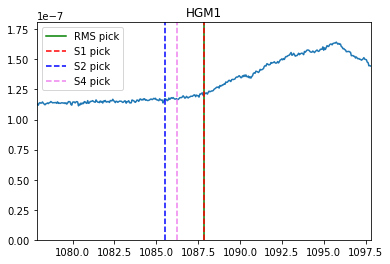

ICU1


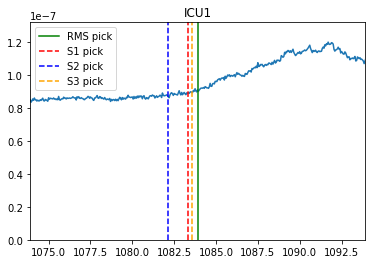

ANO1


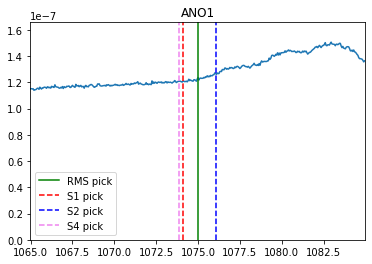

SSK1


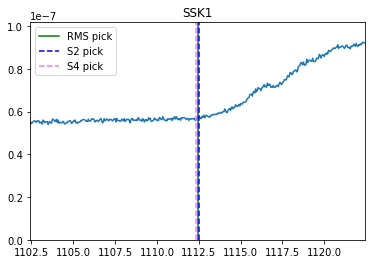

UWA1


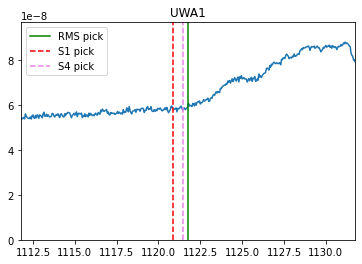

MUR1


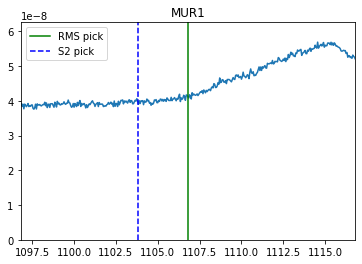

MYM1


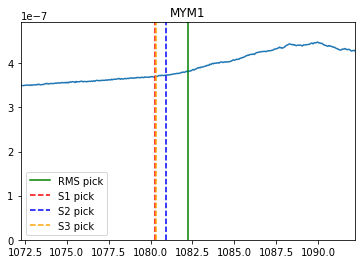

In [53]:
for idx in range(len(stas)):

    sta = stas['Station_name'][idx]
    print(sta)
    
    i_rms = np.where(rms_pick_file_stas == sta)[0]
    rms_pick_date = rms_picks[i_rms,0][0]
    rms_pick_time = rms_picks[i_rms,1][0]
    rms_pick_datetime = UTCDateTime(str(rms_pick_date) + 'T' + str(rms_pick_time) + 'Z')
    rms_starttime = rms_pick_datetime - 10 # 10 seconds before pick time
    rms_endtime = rms_starttime + 120 # full trace will be 2 minutes long
    
    i_s1 = np.where(s1_pick_file_stas == sta)[0]
    s1_pick_date = s1_picks[i_s1,0][0]
    s1_pick_time = s1_picks[i_s1,1][0]
    s1_pick_datetime = UTCDateTime(str(s1_pick_date) + 'T' + str(s1_pick_time) + 'Z')
    s1_starttime = s1_pick_datetime - 10 # 10 seconds before pick time
    s1_endtime = s1_starttime + 120 # full trace will be 2 minutes long
    
    i_s2 = np.where(s2_pick_file_stas == sta)[0]
    s2_pick_date = s2_picks[i_s2,0][0]
    s2_pick_time = s2_picks[i_s2,1][0]
    s2_pick_datetime = UTCDateTime(str(s2_pick_date) + 'T' + str(s2_pick_time) + 'Z')
    s2_starttime = s2_pick_datetime - 10 # 10 seconds before pick time
    s2_endtime = s2_starttime + 120 # full trace will be 2 minutes long
    
    i_s3 = np.where(s3_pick_file_stas == sta)[0]
    s3_pick_date = s3_picks[i_s3,0][0]
    s3_pick_time = s3_picks[i_s3,1][0]
    s3_pick_datetime = UTCDateTime(str(s3_pick_date) + 'T' + str(s3_pick_time) + 'Z')
    s3_starttime = s3_pick_datetime - 10 # 10 seconds before pick time
    s3_endtime = s3_starttime + 120 # full trace will be 2 minutes long
    
    i_s4 = np.where(s4_pick_file_stas == sta)[0]
    s4_pick_date = s4_picks[i_s4,0][0]
    s4_pick_time = s4_picks[i_s4,1][0]
    s4_pick_datetime = UTCDateTime(str(s4_pick_date) + 'T' + str(s4_pick_time) + 'Z')
    s4_starttime = s4_pick_datetime - 10 # 10 seconds before pick time
    s4_endtime = s4_starttime + 120 # full trace will be 2 minutes long

    RMS = read(path + 'filtered_rms/' + str(sta) + '.mseed')
    # RMS.plot()
    
    stream_starttime = RMS[0].stats.starttime
    # print(stream_starttime)
    
    p_arrival_secs_rms = rms_pick_datetime - stream_starttime
    p_arrival_secs_s1 = s1_pick_datetime - stream_starttime
    p_arrival_secs_s2 = s2_pick_datetime - stream_starttime
    p_arrival_secs_s3 = s3_pick_datetime - stream_starttime
    p_arrival_secs_s4 = s4_pick_datetime - stream_starttime
    
    RMS_times = RMS[0].times()
    RMS_data = RMS[0].data
    
    plt.title(sta)
    plt.plot(RMS_times, RMS_data)
    plt.axvline(p_arrival_secs_rms, color = 'green', label = 'RMS pick')
    # plt.axvline(p_arrival_secs_s1, color = 'red', linestyle = '--', label = 'S1 pick')
    # plt.axvline(p_arrival_secs_s2, color = 'blue', linestyle = '--', label = 'S2 pick')
    # plt.axvline(p_arrival_secs_s3, color = 'orange', linestyle = '--', label = 'S3 pick')
    # plt.axvline(p_arrival_secs_s4, color = 'violet', linestyle = '--', label = 'S4 pick')
    
    if sta == 'ANO1':
        plt.axvline(p_arrival_secs_s1, color = 'red', linestyle = '--', label = 'S1 pick')
        plt.axvline(p_arrival_secs_s2, color = 'blue', linestyle = '--', label = 'S2 pick')
        # plt.axvline(p_arrival_secs_s3, color = 'orange', linestyle = '--', label = 'S3 pick')
        plt.axvline(p_arrival_secs_s4, color = 'violet', linestyle = '--', label = 'S4 pick')
    elif sta == 'MYM1':
        plt.axvline(p_arrival_secs_s1, color = 'red', linestyle = '--', label = 'S1 pick')
        plt.axvline(p_arrival_secs_s2, color = 'blue', linestyle = '--', label = 'S2 pick')
        plt.axvline(p_arrival_secs_s3, color = 'orange', linestyle = '--', label = 'S3 pick')
        # plt.axvline(p_arrival_secs_s4, color = 'violet', linestyle = '--', label = 'S4 pick')
    elif sta == 'ICU1':
        plt.axvline(p_arrival_secs_s1, color = 'red', linestyle = '--', label = 'S1 pick')
        plt.axvline(p_arrival_secs_s2, color = 'blue', linestyle = '--', label = 'S2 pick')
        plt.axvline(p_arrival_secs_s3, color = 'orange', linestyle = '--', label = 'S3 pick')
        # plt.axvline(p_arrival_secs_s4, color = 'violet', linestyle = '--', label = 'S4 pick')
    elif sta == 'HGM1':
        plt.axvline(p_arrival_secs_s1, color = 'red', linestyle = '--', label = 'S1 pick')
        plt.axvline(p_arrival_secs_s2, color = 'blue', linestyle = '--', label = 'S2 pick')
        # plt.axvline(p_arrival_secs_s3, color = 'orange', linestyle = '--', label = 'S3 pick')
        plt.axvline(p_arrival_secs_s4, color = 'violet', linestyle = '--', label = 'S4 pick')
    elif sta == 'KST1':
        # plt.axvline(p_arrival_secs_s1, color = 'red', linestyle = '--', label = 'S1 pick')
        plt.axvline(p_arrival_secs_s2, color = 'blue', linestyle = '--', label = 'S2 pick')
        plt.axvline(p_arrival_secs_s3, color = 'orange', linestyle = '--', label = 'S3 pick')
        # plt.axvline(p_arrival_secs_s4, color = 'violet', linestyle = '--', label = 'S4 pick')
    elif sta == 'MUR1':
        # plt.axvline(p_arrival_secs_s1, color = 'red', linestyle = '--', label = 'S1 pick')
        plt.axvline(p_arrival_secs_s2, color = 'blue', linestyle = '--', label = 'S2 pick')
        # plt.axvline(p_arrival_secs_s3, color = 'orange', linestyle = '--', label = 'S3 pick')
        # plt.axvline(p_arrival_secs_s4, color = 'violet', linestyle = '--', label = 'S4 pick')
    elif sta == 'SSK1':
        # plt.axvline(p_arrival_secs_s1, color = 'red', linestyle = '--', label = 'S1 pick')
        plt.axvline(p_arrival_secs_s2, color = 'blue', linestyle = '--', label = 'S2 pick')
        # plt.axvline(p_arrival_secs_s3, color = 'orange', linestyle = '--', label = 'S3 pick')
        plt.axvline(p_arrival_secs_s4, color = 'violet', linestyle = '--', label = 'S4 pick')
    elif sta == 'UWA1':
        plt.axvline(p_arrival_secs_s1, color = 'red', linestyle = '--', label = 'S1 pick')
        # plt.axvline(p_arrival_secs_s2, color = 'blue', linestyle = '--', label = 'S2 pick')
        # plt.axvline(p_arrival_secs_s3, color = 'orange', linestyle = '--', label = 'S3 pick')
        plt.axvline(p_arrival_secs_s4, color = 'violet', linestyle = '--', label = 'S4 pick')
    
    # plt.xlim(1060,1150)
    plt.ylim(0, max(RMS_data[1060*20:1150*20])*1.1)
    plt.xlim(p_arrival_secs_rms-10, p_arrival_secs_rms+10)
    plt.ylim(0, max(RMS_data[int((p_arrival_secs_rms-10)*20):int((p_arrival_secs_rms+10)*20)])*1.1)
    plt.legend()
    plt.show()
    

    # RMS_trim_rms = RMS.trim(starttime = rms_starttime, endtime = rms_endtime, pad = True, fill_value = 0)
    # RMS_trim.plot()

    # Extracting just the RMS data, now trimmed properly, and saving it to a 
    # new miniSEED file.

    # RMS_times_trim = RMS_trim[0].times()
    # RMS_data_trim = RMS_trim[0].data
    # RMS_trim[0].stats.channel = 'tBSR'

    # plt.title(sta)
    # plt.plot(RMS_times_trim, RMS_data_trim)
#     plt.legend()
#     plt.show()

#     Plot after each station
#     if no_data: 
#         pass
#     else:
#         plt.legend(ncol = 2)
#         plt.show()

#     # Create folder for the event
#     eq_sta_save_dir = path_to_files + 'strain_data/filtered_trimmed_rms/' + str(cut_ot) + '_M' + str(mags[idx]) + '/'
# #                 print(eq_sta_save_dir)
#     if os.path.isdir(eq_sta_save_dir):
#         pass
#     else:
#         os.makedirs(eq_sta_save_dir)

#     RMS_trim.write(eq_sta_save_dir + sta + '.mseed', format = 'MSEED')

# plt.legend(ncol = 2)
# plt.show()  